In [1]:
path_='.'

In [2]:
import mpl_toolkits.mplot3d as a3
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.linalg as sp
import math
import os
import glob 
import torch as th
from random import choices
import tqdm
import pickle
# save path 
save_path = path_
num_chkpoints = 2043

t_jialin = np.array([    0,     1,    63,   125,   187,   249,   251,   313,   375,
      437,   499,   501,   563,   625,   687,   749,   751,   813,
      875,   937,   999,  1001,  1063,  1125,  1187,  1249,  1500,
     1750,  2000,  2250,  2500,  2750,  3000,  3250,  3500,  3750,
     4000,  4250,  4500,  4750,  5000,  5250,  5500,  5750,  6000,
     6250,  6500,  7250,  8250,  9250, 10250, 11250, 12250, 13250,
    14250, 15250, 16250, 19000, 22750, 26500, 30250, 34000, 37750,
    41500, 45250, 49000, 50000])
t_save = set(list(np.arange(1000))+list(t_jialin) + list(np.arange(15000,35000,20)))
t_save = list(t_save)
t_save.sort()
 
jialin_ind = [np.where(t_save==k)[0][0] for k in t_jialin]

label_m=['AM',
 'GM',
 'HM',
 'Sqrt AM',
 'Bhattacharyya',
 "Jeffrey's"]

# Data

In [ ]:


def dbhat(x1, x2, reduction='mean', dev='cuda', debug=False, chunks=1000):
    # x1, x2 shape (num_points, num_samples, num_classes)
    np1, ns, _ = x1.size()
    np2, ns, _ = x2.size()
   
    x1, x2 = x1.transpose(0, 1), x2.transpose(0, 1)
    w = np.zeros([np1, np2])

    chunks = chunks or 1;
    for aa in (th.chunk(th.arange(ns), chunks)):
        xx1 = x1[aa, :].to(dev)
        xx2 = x2[aa, :].to(dev)
        aa = th.sqrt(aa)
        w_ = -th.log(th.bmm(th.sqrt(xx1), th.sqrt(xx2).transpose(1, 2)))
        w_[w_ > 1e12] = 100
        w_[w_ < 0] = 0
        w += w_.sum(0).cpu().numpy()
    if reduction == 'mean':
        return w / ns
    else:
        return w

def projection(Dbhatt):

    ne = 3
    n = Dbhatt.shape[0]
    l = np.eye(Dbhatt.shape[0]) - 1.0/Dbhatt.shape[0]
    w = -l @ Dbhatt @ l / 2

    e1, v1 = sp.eigh(w, driver='evx', check_finite=False,
                     subset_by_index=[n-(ne+1), n-1])
    e2, v2 = sp.eigh(w , driver='evx', check_finite=False,
                     subset_by_index=[0, (ne+1)])
    e = np.concatenate((e1, e2))
    v = np.concatenate((v1, v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e, v = e[ii], v[:, ii]
    xp = v*np.sqrt(np.abs(e))
    
    return xp, e, v

def new_points_in_embedding(new_points, p_list, dist_mat, eig_values, eig_vecs, distance = dbhat, embed_dimension =3):

    dp=distance(th.Tensor(new_points),th.Tensor(p_list),chunks= 20000)   
        
    d_mean=np.mean(dist_mat,0)
    d_mean_mean=np.mean(d_mean)
    dp_mean=dp-np.mean(dp)-d_mean+d_mean_mean
    dp_mean=-.5*dp_mean
    sqrtsigma=np.sqrt(np.abs(eig_values))
    
    return ((1/sqrtsigma)*np.matmul(dp_mean,eig_vecs))

In [ ]:
def theta(p):
    # converts to natural param
    # assume p is of the frm n_model x n_image x n_class
    theta_ = np.log(p/(10**-5+1-p[:,:,:-1].sum(2,keepdims=True)))
    return theta_

def F(theta):
    # log partition function for categorial distribution
    return np.log(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF(theta):
    # Gradient of log partition function for categorial distribution
    return np.exp(theta[:,:,:-1])/(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF_inv(eta):
    # reciprocal of the gradient of log partition function for categorial distribution
    return np.log(eta/(1-eta.sum(2,keepdims = True)+1e-8))

def g_mean(p):
    # geometric mean as the initial point of guess 
    gm = np.exp(np.log(p).mean(0,keepdims=True))
    return gm/gm.sum(1,keepdims=True)

def Bhat_centroid(p):
    """
    Based on 
    Nielsen, Frank, and Sylvain Boltz. "The burbea-rao and bhattacharyya centroids." IEEE Transactions on Information Theory 57.8 (2011): 5455-5466.
    https://arxiv.org/abs/1004.5049
    
    -- utilizes iterative concave-convex optimization algorithm

    """
    # initialization
    c = p.mean(0,keepdims=True)
    #Concave Convex opt
    err1=[]
    err2=[]
    
    for _ in range(100):
        
        c_t= nablaF_inv(nablaF(0.5*theta(p)+0.5*theta(c)).mean(0,keepdims=True))
        c_t = np.exp(c_t)/(1+np.exp(c_t).sum(2,keepdims=True))
        c_t = th.cat((c_t,1-c_t.sum(2,keepdims=True)),2)
        c=c_t
    return c_t

from scipy.special import lambertw 
from scipy.stats import gmean

def lambert(z):
    return lambertw(z).real

def sKL_centroid(p):
    a = np.mean(p,0)
    g = gmean(p,0)
    return a/lambert(a*np.exp(1)/g)

# training data

In [3]:
xp =pickle.load(open('data/inpca_coord.p', 'rb'))

In [4]:
import pandas as pd
xp = pd.DataFrame(xp, columns=[f'x{i}' for i in range(9)])

In [5]:
xp['Centroid'] = 'original'
for m in range(6):
    xp.loc[2010+67*m:2010+67*(m+1), 'Centroid'] = label_m[m]

In [6]:
xp['style'] = '1'

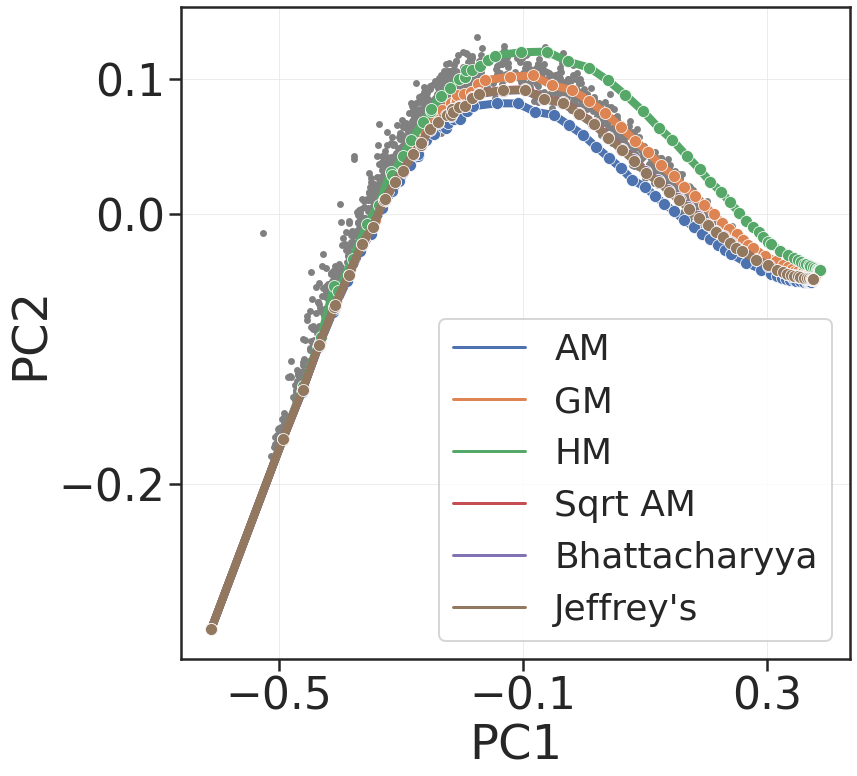

In [13]:
f, ax=plt.subplots(figsize=(12,12))
import seaborn as sns
sns.set(context='poster',
        style='ticks',
        font_scale=2,
        rc={'axes.grid': True,
            'grid.color': '.9',
#             'lines.linewidth': ,
            'grid.linewidth': 0.75})
sns.lineplot(data=xp.iloc[2010:-1], x='x0',y='x1', hue='Centroid',ax=ax, marker='.',  markersize=24, lw=8)
sns.scatterplot(data=xp.iloc[:2010], x='x0',y='x1', color='grey', ax=ax, s=48, linewidth=0)
ax.set(xlabel='PC1', ylabel='PC2',xticks=[-0.5,-0.1,0.3], yticks=[-0.2, 0, 0.1])
plt.legend(fontsize=36)

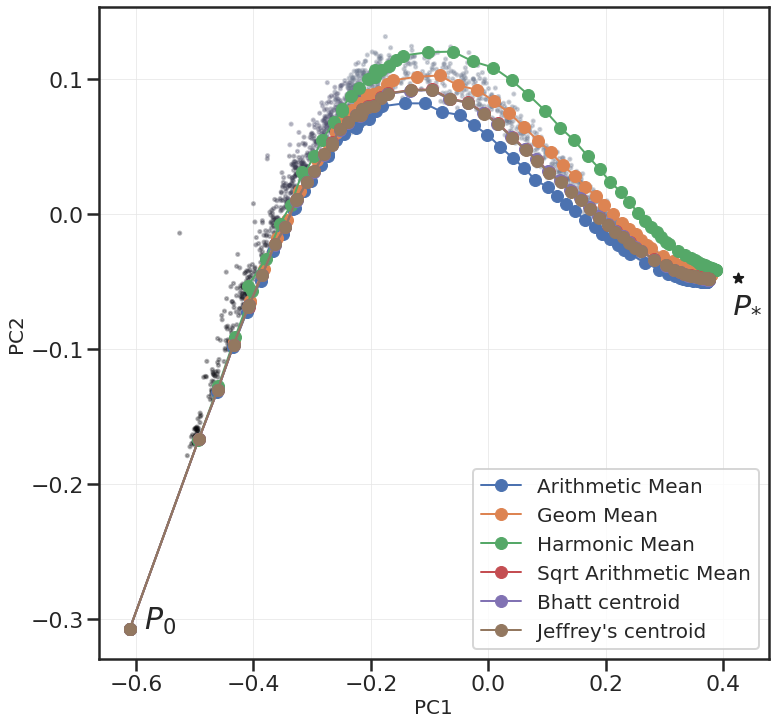

In [7]:
fig = plt.figure(figsize=(12,12))
import seaborn as sns
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid': True,
            'grid.color': '.9',
#             'lines.linewidth': 0.5,
            'grid.linewidth': 0.75})
plt.scatter(xp[:2010,0],xp[:2010,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
for m in range(6):
    plt.plot(xp[2010+67*m:2010+67*(m+1),0],xp[2010+67*m:2010+67*(m+1),1],'o-',linewidth=2, label=label_m[m])
plt.text(xp[-1,0]-0.01,xp[-1,1]-0.025,r'$P_{*}$',fontsize=30)
plt.scatter(xp[-1,0],xp[-1,1],c='k',marker= '*',s=100)

plt.text(xp[0,0]+0.025,xp[0,1],r'$P_{0}$',fontsize=30)

plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


# test data 

In [7]:
xp_test =pickle.load(open('data/inpca_coord_test.p', 'rb'))

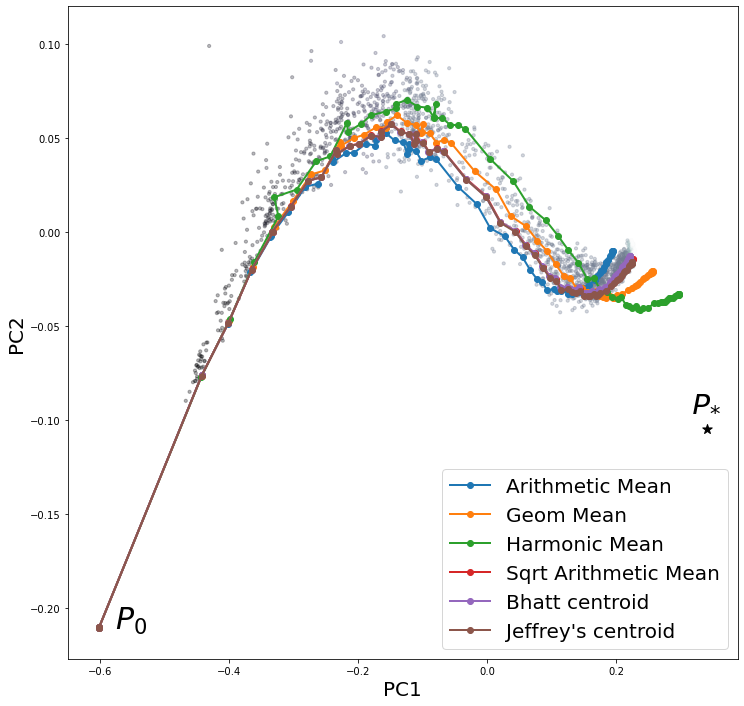

In [8]:
fig = plt.figure(figsize=(12,12))
plt.scatter(xp_test[:2010,0],xp_test[:2010,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
for m in range(6):
    plt.plot(xp_test[2010+67*m:2010+67*(m+1),0],xp_test[2010+67*m:2010+67*(m+1),1],'o-',linewidth=2, label=label_m[m])
plt.scatter(xp_test[-1,0],xp_test[-1,1],c='k',marker= '*',s=100)
plt.text(xp_test[-1,0]-0.025,xp_test[-1,1]+0.01,r'$P_{*}$',fontsize=30)
plt.text(xp_test[0,0]+0.025,xp_test[0,1],r'$P_{0}$',fontsize=30)

plt.axis('tight')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)

In [10]:
progress_err_ds= pickle.load(open('data/progress_err_ds.p'), 'rb'))

In [12]:

progress_AM = progress_err_ds['progress_AM'] 
validation_err_AM = progress_err_ds['validation_err_AM'] 

progress_GM =progress_err_ds['progress_GM']
validation_err_GM =progress_err_ds['validation_err_GM'] 

progress_HM =progress_err_ds['progress_HM']
validation_err_HM =progress_err_ds['validation_err_HM']

progress_sqrtAM = progress_err_ds['progress_sqrtAM']
validation_err_sqrtAM  = progress_err_ds['validation_err_sqrtAM']

progress_bhatt = progress_err_ds['progress_Bhatt']
validation_err_bhatt = progress_err_ds['validation_err_Bhatt']

progress_skl = progress_err_ds['progress_sKL']
validation_err_skl =progress_err_ds['validation_err_sKL'] 




In [15]:
progress_err_ds= pickle.load(open('data/progress_err_ds.p', 'rb'))

In [16]:
r = pd.DataFrame(np.vstack([t.squeeze() for t in progress_err_ds.values()]).T, columns=list(progress_err_ds.keys()))

In [17]:
for n in ['AM', 'GM', 'HM', 'sqrtAM', 'Bhatt', 'sKL']:
    r[f'validation_err_{n}'] = 1 - r[f'validation_err_{n}']

In [26]:
r.iloc[66]

progress_AM              0.715315
validation_err_AM        0.249512
progress_GM              0.760154
validation_err_GM        0.209055
progress_HM              0.784367
validation_err_HM        0.189470
progress_sqrtAM          0.738769
validation_err_sqrtAM    0.227869
progress_Bhatt           0.736288
validation_err_Bhatt     0.231353
progress_sKL             0.738411
validation_err_sKL       0.226862
Name: 66, dtype: float64

[Text(0.5, 0, 'Progress'),
 Text(0, 0.5, 'Test Error'),

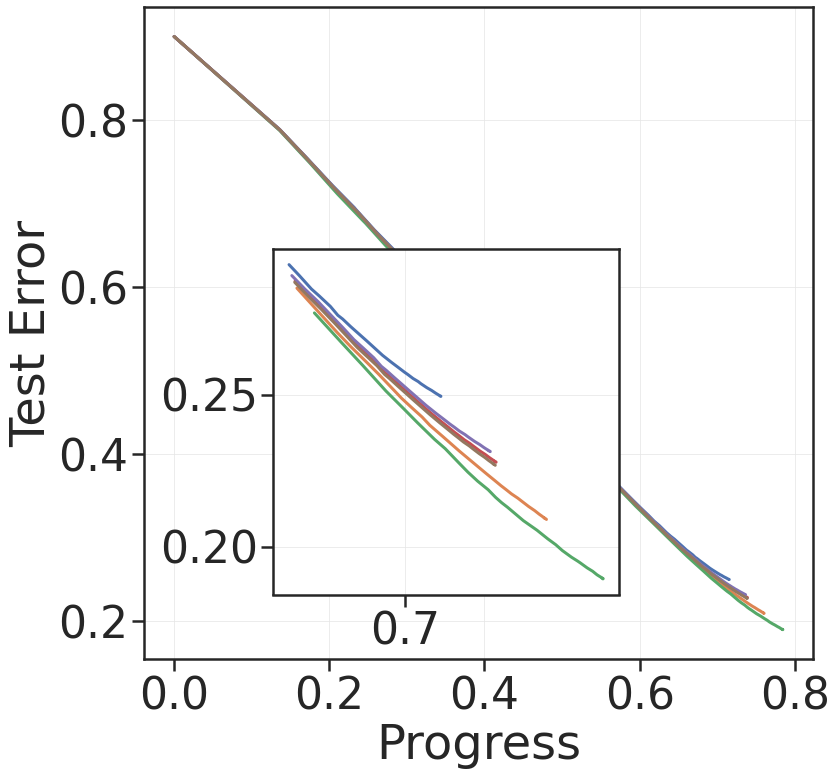

In [23]:
f, ax=plt.subplots(figsize=(12,12))
import seaborn as sns
sns.set(context='poster',
        style='ticks',
        font_scale=2,
        rc={'axes.grid': True,
            'grid.color': '.9',
#             'lines.linewidth': 0.5,
            'grid.linewidth': 0.75})
ax2 = f.add_axes([0.275, 0.2, 0.4, 0.4])
for n in ['AM', 'GM', 'HM', 'sqrtAM', 'Bhatt', 'sKL']:
    sns.lineplot(data=r, x=f'progress_{n}', y=f'validation_err_{n}', ax=ax)
    sns.lineplot(data=r[r[f'progress_{n}'] >= 0.65], x=f'progress_{n}', y=f'validation_err_{n}', ax=ax2)
ax2.set(xlabel='', ylabel='', xticks=[.7], yticks=[.2, 0.25])
ax.set(xlabel='Progress', ylabel='Test Error', xticks=[0,0.2, 0.4, 0.6,0.8], yticks=[0.2, 0.4, 0.6,0.8])

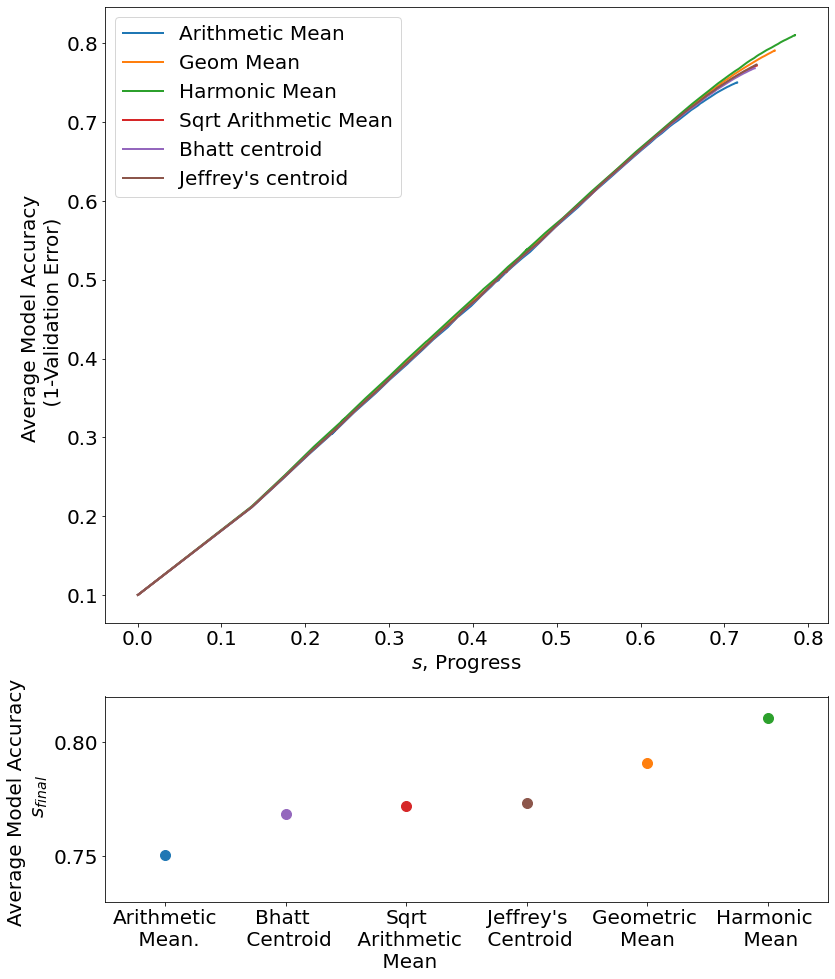

In [14]:
import matplotlib
font = {
        'size'   : 20}

matplotlib.rc('font', **font)
label_m = [r'Arithmetic Mean',r'Geom Mean',r'Harmonic Mean',r'Sqrt Arithmetic Mean',r'Bhatt centroid ',"Jeffrey's centroid"]
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,14))

a0.plot(progress_AM,validation_err_AM,label = label_m[0],linewidth=2)
a0.plot(progress_GM,validation_err_GM,label = label_m[1],linewidth=2)

a0.plot(progress_HM,validation_err_HM,label = label_m[2],linewidth=2)
a0.plot(progress_sqrtAM,validation_err_sqrtAM,label = label_m[3],linewidth=2)
a0.plot(progress_bhatt,validation_err_bhatt,label = label_m[4],linewidth=2)
a0.plot(progress_skl,validation_err_skl,label = label_m[5],linewidth=2)
a0.legend()
a0.set_ylabel('Average Model Accuracy \n (1-Validation Error)')
a0.set_xlabel('$s$, Progress')
#plt.savefig('progress_vs_validation_err_averaging.pdf', dpi=300)

a1.scatter(0,validation_err_AM[-1],s=100)
a1.scatter(4,validation_err_GM[-1],s=100 )
a1.scatter(5,validation_err_HM[-1],s=100)
a1.scatter(2,validation_err_sqrtAM[-1] ,s=100)
a1.scatter(1,validation_err_bhatt[-1],s=100)
a1.scatter(3,validation_err_skl[-1] ,s=100)


a1.set_xticks([0,1,2,3,4,5],['Arithmetic\n Mean.','Bhatt \n Centroid','Sqrt\n Arithmetic\n Mean','Jeffrey\'s\n Centroid','Geometric \nMean','Harmonic \n Mean'])
a1.set_yticks([0.75,0.80])
a1.axis([-0.5,5.5,0.73,0.82])
a1.set_ylabel('Average Model Accuracy \n $s_{final}$')
#plt.xlabel('Type of Averaging')
f.tight_layout()
f.savefig('progress_vs_validation_err_averaging.pdf', dpi=300)
